In [33]:
import numpy as np
import matplotlib.pyplot as plt

import ohbemn
from ohbemn import Solver, Region, ohpy, Orientation
from ohbemn.ohpy import wave, source
ohbemn.style_plots()

wave length: [98.67208743]
elements: 512


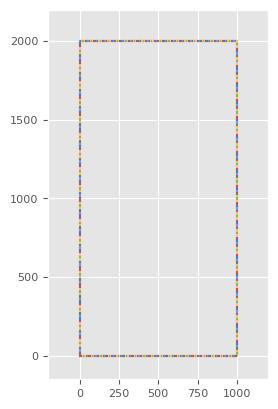

In [49]:
T = 8.   # [s]
f = 1/T
d = 40.  # [m]
c, cg, k = wave.wavec_interm(T, d)
k = k[0]
lmbda = c/f
print("wave length:", c/f)

region = Region.rectangle(1000, 2000, 128, 128)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 2200])
ax.set_aspect('equal')

print("elements:", region.len())

The breakwater is closed, except from 400 to 600 at y=0. Where it is closed it is defined by:

$\frac{\partial \phi}{\partial n} = 0$

which, since it is defined on the derivative of the velocity potential is a Neumann boundary condition. Where it is open, $\phi$ and $\partial \phi$ is defined by the source.

In [35]:
bc = region.neumann_boundary_condition()


centers = region.centers()
normals = region.normals()



In the interior, there is no other incoming field.

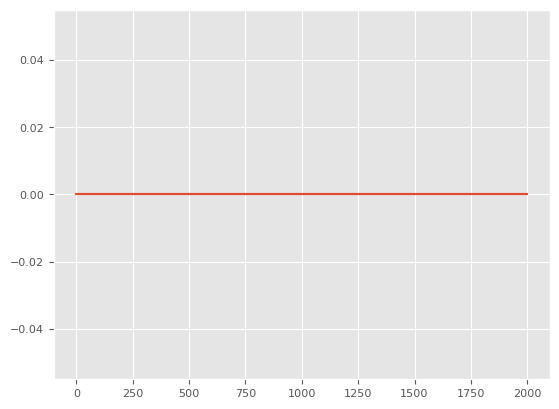

In [36]:
bi = region.boundary_incidence()

# Try to define incidence field
for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]
    
    phi = source.plane(0, k, *x)
    v = source.dplane(0, k, *x, -n)
    
    # opening
    if x[1] < 0.1 and (x[0] >= 450. and x[0] <= 475.):    
        bc.beta[i] = 0.
        bc.alpha[i] = 1.
        

        bc.f[i] = 0
        bi.phi[i] = phi
        bi.v[i] = 0
    else:
        #bc.beta[i] = 0
        #bc.alpha[i] = 0
        if x[1] > 1999: # and x[0] > 0.1 and x[0] < 999:
            bc.f[i] = 0
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.
        elif x[1] < 0.1:
            bc.f[i] = 0
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.
        else:
            bc.f[i] = 0.
            bc.alpha[i] = 1j*k
            bc.beta[i] = 1.
            #bc.beta[i] = 1.
            #bc.alpha[i] = 0.
            continue
            if x[0] > 500:
                bc.f[i] = 0
                bc.beta[i] = -1j*k
                bc.alpha[i] = 1.
            else:
                bc.f[i] = 0
                bc.beta[i] = 1j*k
                bc.alpha[i] = 1.

        
plt.figure()
plt.plot(centers[:,1], np.abs(bc.f))

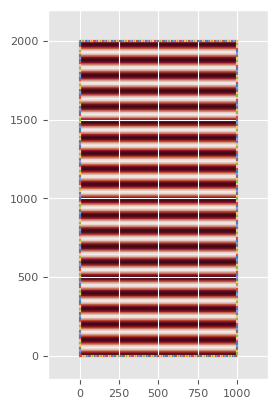

In [37]:
# Sample grid in the interior

x = np.arange(0.01, 999.1, 10)
y = np.arange(0.01, 1999.1, 10)
xx, yy = np.meshgrid(x, y)


# Incident field without break-water
fI = source.plane(0, k, xx, yy)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 2200])
ax.set_aspect('equal')
ax.imshow(fI.real, origin='lower', extent=[0, 1000, 0, 2000])

In [38]:
# Solve boundary.

solver = Solver(region)
boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)

computing boundary matrices..
solving linear equations..
done.


/tmp/ipykernel_44325/4066350755.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)


In [39]:
# Solve samples in interior
#x = np.arange(0, 200, 2)
#y = np.arange(0, 200, 2)
#xx, yy = np.meshgrid(x, y)
ep = np.vstack((xx.ravel(), yy.ravel())).T

print('Solving for interior points:', ep.shape)
eF = boundary_solution.solve_samples(np.zeros(ep.shape[0]), ep)

Solving for interior points: (20000, 2)


Text(0.5, 1.0, '$|\\phi|$')

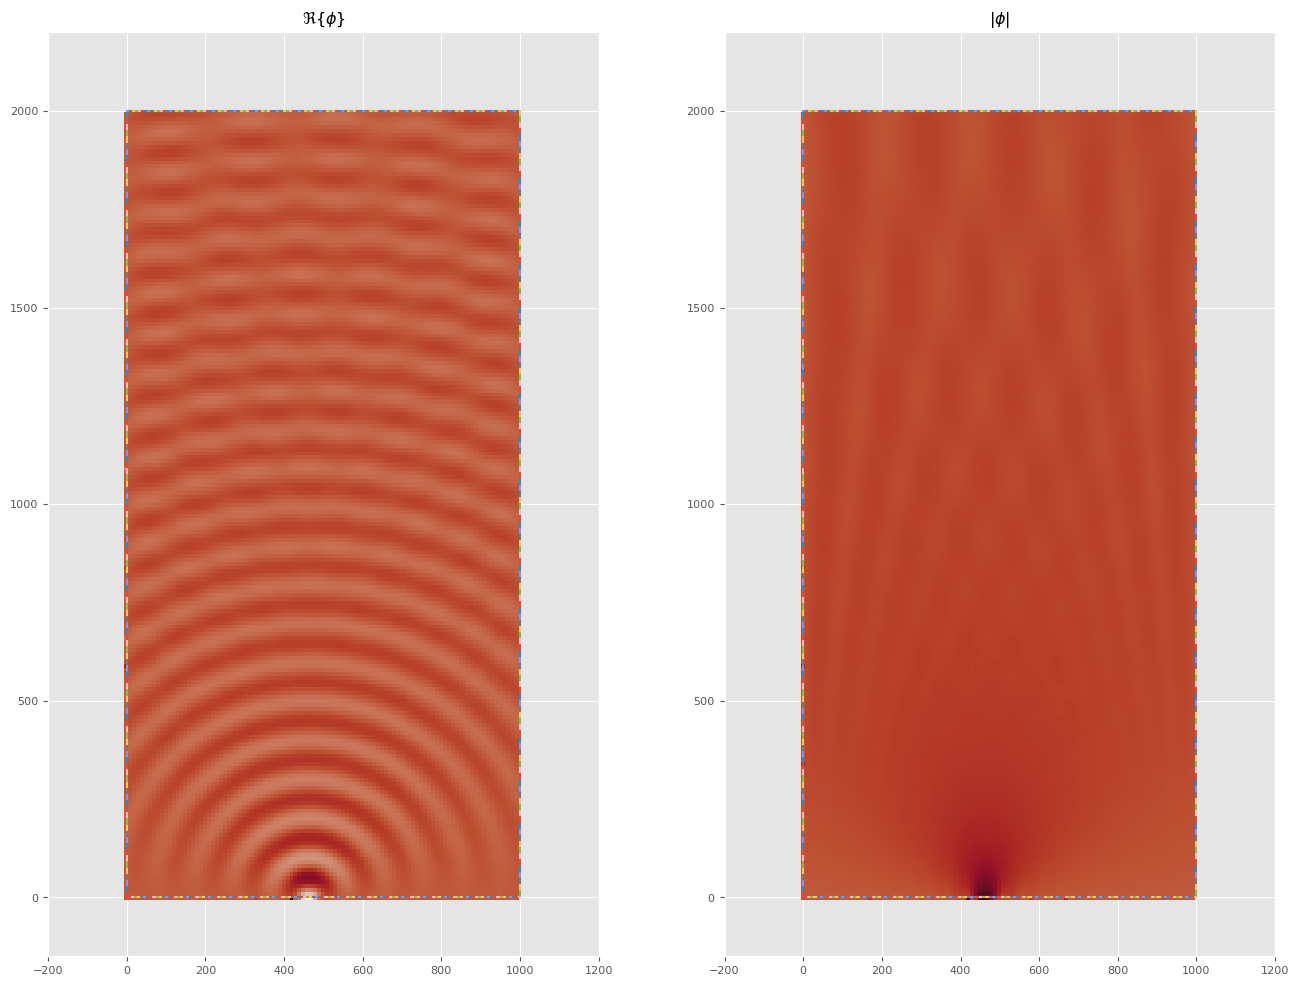

In [44]:
eFp = eF.phis.reshape(xx.shape)
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 12))
region.plot(ax1)
ax1.set_aspect('equal')
ax1.pcolor(xx, yy, np.real(eFp), vmin=-1, vmax=1)
ax1.set_xlim([-200, 1200])
ax1.set_ylim([-150, 2200])
ax1.set_title('$\\Re\\{\\phi\\}$')

region.plot(ax2)
ax2.set_aspect('equal')
ax2.pcolor(xx, yy, np.abs(eFp), vmin=-1, vmax=1)
ax2.set_xlim([-200, 1200])
ax2.set_ylim([-150, 2200])
ax2.set_title('$|\\phi|$')

In [47]:
f.savefig('figures/breakwater_closed_single_slit.png', dpi=250, bbox_inches=0)

In [56]:
# Analytic solution to diffraction
#
# https://en.wikipedia.org/wiki/Fraunhofer_diffraction_equation#Narrow_rectangular_slit or Borne & Wolf, 2011

def U(a, W, lmbda, x, z):
    """
    Args:
        a: Amplitude
        W: Width of the slit
        lmbda: Wavelength
        x: Position in the x-axis
        z: Distance from the slit
    """
    return a * W * np.sinc(((np.pi * W * x) / (z * lmbda))/np.pi)
    
#lmbda = c/f
a = 1.0
W = 475 - 450
x0 = 450

u = U(a, W, lmbda, x - x0, 100)
print(x, u)

[1.0000e-02 1.0010e+01 2.0010e+01 3.0010e+01 4.0010e+01 5.0010e+01
 6.0010e+01 7.0010e+01 8.0010e+01 9.0010e+01 1.0001e+02 1.1001e+02
 1.2001e+02 1.3001e+02 1.4001e+02 1.5001e+02 1.6001e+02 1.7001e+02
 1.8001e+02 1.9001e+02 2.0001e+02 2.1001e+02 2.2001e+02 2.3001e+02
 2.4001e+02 2.5001e+02 2.6001e+02 2.7001e+02 2.8001e+02 2.9001e+02
 3.0001e+02 3.1001e+02 3.2001e+02 3.3001e+02 3.4001e+02 3.5001e+02
 3.6001e+02 3.7001e+02 3.8001e+02 3.9001e+02 4.0001e+02 4.1001e+02
 4.2001e+02 4.3001e+02 4.4001e+02 4.5001e+02 4.6001e+02 4.7001e+02
 4.8001e+02 4.9001e+02 5.0001e+02 5.1001e+02 5.2001e+02 5.3001e+02
 5.4001e+02 5.5001e+02 5.6001e+02 5.7001e+02 5.8001e+02 5.9001e+02
 6.0001e+02 6.1001e+02 6.2001e+02 6.3001e+02 6.4001e+02 6.5001e+02
 6.6001e+02 6.7001e+02 6.8001e+02 6.9001e+02 7.0001e+02 7.1001e+02
 7.2001e+02 7.3001e+02 7.4001e+02 7.5001e+02 7.6001e+02 7.7001e+02
 7.8001e+02 7.9001e+02 8.0001e+02 8.1001e+02 8.2001e+02 8.3001e+02
 8.4001e+02 8.5001e+02 8.6001e+02 8.7001e+02 8.8001e+02 8.9001

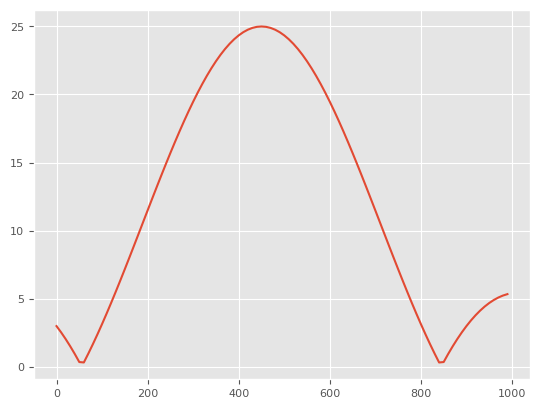

In [57]:
plt.figure()
plt.plot(x, np.abs(u))